# The Finite Element Method

The goal of the Finite Element Method is to find a "simple" function space in which we can find approximate solutions to PDEs. More importantly, we would like to balance the computational complexity of finding these solutions with the quality of the approximation.

That is, we would like to convert a variational formulation 

$$a(u,v) = l(v)$$ with $$\begin{align*} a&:\;V\times W\to \mathbb{R}\\l&:\;W\to\mathbb{R}\end{align*}$$ to a linear algebra problem $$\mathbf{A}_hu_h = b$$ 

Generally, we use the Sobolev space $H^1_0$ for the solution space $V$ and the test function space $W$. If the boundary conditions are not Dirichlet, or if we have not applied the "lifting" procedure to Dirichlet boundary conditions, we use $H^1$ instead.

We will start by choosing a basis for $H^1_0(\Omega)$ with basis functions $\{\phi_i\}_{i=1,2,\ldots}$ that overlap minimally.

# Decomposition of 1D Domains

We'll start by discussing the finite element method in 1 dimension. That is, we would like to approximately solve the varational formulation of the Poisson problem (in the weak sense), on the interval $\Omega=[0,1]$. We can recall the variational formulation of the Poisson problem to be: 

<a id="poisson_varform"></a>
<div class="alert alert-block alert-info" style="color:black">
Find $u\in H^1_0(\Omega)$, such that, for all $v\in H^1_0(\Omega)$: $$a(u,v) = l(v)$$ with $$\begin{align}a(u,v) = \langle \nabla u, \nabla v\rangle_{L^2} &= \int_\Omega\nabla u\cdot\nabla v\: dx\\ f(v) &= \int_\Omega fv\:dx\end{align}$$
</div>

## Hat Functions

We can also recall the Ritz-Galerkin method of approximating the solution and test spaces $H^1_0$ with some finite-dimensional subspace $V_N$. As an approximation for $\Omega=[a,b]$, we use $\{x_i\}_{i=0\ldots N+1}$, with $a=x_0\lt x_i \lt x_{i+1}\lt x_{N+1}=b$. As a potential basis for $V_N\subset H^1_0([a,b])$, we propose the _hat functions_ $\{\phi_j\}_{j=1\ldots N}$: $$\phi_j(x) = \begin{cases}\frac{x-x_{j-1}}{x_j-x_{j-1}} & x\in[x_{j-1},x_j]\\\frac{x_{j+1}-x}{x_{j+1}-x_j} & x\in[x_j,x_{j+1}]\\0 & x\notin[x_{j-1},x_{j+1}]\end{cases}$$

<div class="alert alert-block alert-success" style="color:black">
    The function $$s^{(N)}(x) = \sum_{j=1}^N u(x_j)\phi_j(x)$$ is an element of $V_N\in H^1_0(\Omega)$ and is a continuous, piecewise linear, function (a "linear spline") interpolating $u(x)$.
</div>

---

# Example 1: Linear Splines

We would like to solve the [variational formulation of the Poisson problem](#poisson_varform) using the hat functions. For this example, we will use $\Omega=[0,1]$ and set $f(x) = 1$ and $u(0)=u(1)=0$. We already know the analytical solution to this problem: $$u(x) = -\frac{1}{2}x^2 + \frac{1}{2}x$$ We will search for the approximate solution $u_h(x)$

In [1]:
u_exact = lambda x: -0.5*x**2 + 0.5*x

import matplotlib.pyplot as plt
from matplotlib import rc, cm
import numpy as np

# the number of hat functions to use
# this will be two less than the number of grid points
# since each hat function requires two intervals 
N = 2
x_i = np.linspace(0,1,N+2)
h = 1/(N+2)
# for nice plotting
x = np.linspace(0,1,200)

## Visualizing Hat Functions
In order to compute the value of $$A_{h,ij}=a(\phi_i,\phi_j) = \langle\nabla\phi_i,\nabla\phi_j\rangle_{L^2} = \int_\Omega \nabla\phi_i\cdot\nabla\phi_j\:dx$$ we need to know a bit more about the hat functions.

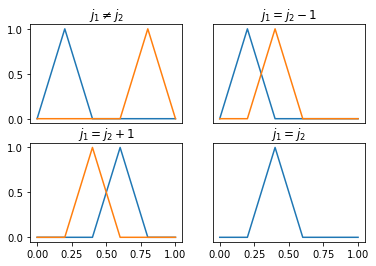

In [2]:
# let's plot a couple of hat functions:
# (excuse the verbosity of matplotlib)
fig = plt.figure()
ax = fig.add_subplot(2,2,1)
ax.set_title("$j_1 \\neq j_2$")
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,1,0,0,0,0])
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,0,0,0,1,0])
ax.get_xaxis().set_visible(False)
ax = fig.add_subplot(2,2,2)
ax.set_title("$j_1=j_2-1$")
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,1,0,0,0,0])
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,0,1,0,0,0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = fig.add_subplot(2,2,3)
ax.set_title("$j_1=j_2+1$")
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,0,0,1,0,0])
ax.plot([0,0.2,0.4,0.6,0.8,1],[0,0,1,0,0,0])
ax = fig.add_subplot(2,2,4)
ax.set_title("$j_1= j_2$")
ax.get_yaxis().set_visible(False)
_ = ax.plot([0,0.2,0.4,0.6,0.8,1],[0,0,1,0,0,0])

## Computing Values of the Bilinear Form $a(\phi_i,\phi_j)$

The first thing we notice is that we can split the integral $\int_\Omega$ into a sum of smaller integrals. $$ \int_\Omega\cdot\:dx = \sum_{j=1}^{N+1}\int_{x_j-1}^{x_j}\cdot\:dx$$
We apply this to the bilinear form $a(\phi_i,\phi_j)$, and find that $$a(\phi_i,\phi_j) = \int_a^b\phi_i'\phi_j'\:dx = \begin{cases} \frac{1}{x_j-x_{j-1}}+\frac{1}{x_{j+1}-x_j} & i = j\\\frac{-1}{x_i-x_{i-1}} & i = j+1\\\frac{-1}{x_j-x_{j-1}} & i = j-1\\ 0 & \text{otherwise}\end{cases}$$

If $x_i-x_{i-1}=h$ is constant: $$a(\phi_i,\phi_j)=\begin{cases}\frac{2}{h} & i=j\\\frac{-1}{h} & i = j\pm 1\\0 & \text{otherwise}\end{cases}$$

It is now very easy to compute the matrix entries $A_{h,ij} = a(\phi_i,\phi_j)$. $$A_{h} = \frac{1}{h}\begin{pmatrix} 2 & -1 & 0 & \\-1 & 2 & -1 & \cdots\\0&-1&2&\\&\vdots&&\end{pmatrix}$$ and to compute the values $$b_i = \int_\Omega f(x)\phi_j(x)\:dx$$ since $\int_\Omega\phi_j = h$.

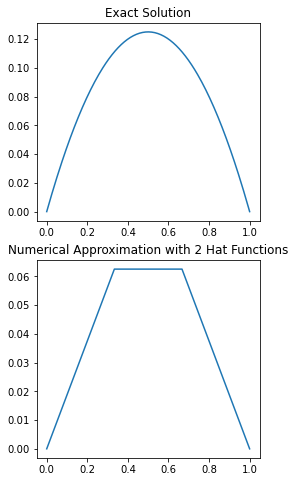

In [3]:
A = (-np.eye(N,k=-1)+2*np.eye(N)-np.eye(N,k=1))
A *= 1/h**2
b =  np.ones((N,1))

# Apply boundary conditions at x=0 and x=1 where u is known
u_h = np.zeros((N+2,1))
u_h[1:N+1,:] = np.linalg.solve(A,b)
fig = plt.figure(figsize=plt.figaspect(2))
ax = fig.add_subplot(2,1,1)
ax.set_title("Exact Solution")
ax.plot(x,u_exact(x))
ax = fig.add_subplot(2,1,2)
ax.set_title("Numerical Approximation with {} Hat Functions".format(N))
_ = ax.plot(x_i,u_h)

Note that this works out to be identical to the finite difference case! However, this is pure coincedence and will not have any bearing on extensions to higher-dimensional FEM.

It is also possible to use "hat functions" that are polynomials of an arbitrary degree. However, we must use more points $x\in[x_j,x_{j+1}]$ to uniquely determine these polynomials.

---

# Triangulation of 2D Domains

To extend the above ideas to domains $\Omega\subset\mathbb{R}^2$, we decompose $\Omega$ into triangles.
<div class="alert alert-block alert-info" style="color:black"> 
    A <i>triangulation</i> $\mathcal{T} = \{K_i\}_{i=1,2,\ldots}$ is a decompostion of a (usually polygonal) domain $\Omega\subset\mathbb{R}^2$ into triangles $K_i$. $\mathcal{T}$ is called <i>regular</i> if the intersection of two triangles $K_1,\:K_2\in\mathcal{T}$ is either empty, a vertex of $K_1$ and $K_2$, or a shared edge between $K_1$ and $K_2$. The set of vertices of $\mathcal{T}$ is deonted by $$\mathcal{N(T)}=\{p\in\mathbb{R}^2:\: p\text{ is a vertex of some } K\in\mathcal{T}\}$$
</div>

We choose that subdomains $K_i$ are triangles, but in principle, we could combine triangles with other polygons, as long as $\bar{\Omega} = \cup_{K}\bar{K_i}$ and $K_i\cap K_j = 0$ when $i\neq j$.
On a computer, $\mathcal{T}$ is typically stored in two parts:
- A list of vertices $p_j\in\mathcal{N(T)}$
- A connectivity list that denotes which vertices belong to which triangle

# Example 2: GMSH
`gmsh` is a tool used to create meshes for finite element solvers. It has complete, if rather opaque documentation [here](https://gmsh.info/).

It can be installed locally with the python package manager `pip`:

```pip3 install gmsh```

Below is a brief reference to show how to use `gmsh`.

In [4]:
import gmsh
gmsh.initialize() # start gmsh
gmsh.open("unitSquare1.msh") # load a 4-triangle decomposition of the unit square
print("Loaded model {}. It is {}D.".format(gmsh.model.getCurrent(),gmsh.model.getDimension()))

# a list of things in the model, stored as (dimension, tag pairs)
entities = gmsh.model.getEntities() 
for e in entities:
    dimension = e[0]
    tag = e[1]
    entity_type = gmsh.model.getType(dimension, tag)
    entity_name = gmsh.model.getEntityName(dimension, tag)
    print("Entity {} {} of type {}".format(entity_name,str(e),entity_type))
    
    # get the mesh nodes for this entity
    # these
    node_tags, node_positions, node_parameters = gmsh.model.mesh.getNodes(dimension, tag)
    # get element information for this entity
    element_types, element_tags, element_node_tags = gmsh.model.mesh.getElements(dimension, tag)
    
    num_elements = sum([len(i) for i in element_tags])
    print("  This entity's mesh has {} nodes and {} elements".format(len(node_tags),num_elements))
    for tag_list in element_tags:
        for element_tag in tag_list:
            el_type, el_node_tags = gmsh.model.mesh.getElement(element_tag)
            print("  Element {} is of type {} and has {} nodes".format(element_tag, el_type, len(el_node_tags)))
            for el_node in el_node_tags:
                pos, _ = gmsh.model.mesh.getNode(el_node)
                print("    Node {} has position {}".format(el_node,pos))
    print("\n")

gmsh.finalize() # end gmsh

Loaded model unitSquare1. It is 2D.
Entity  (1, 1) of type Discrete curve
  This entity's mesh has 2 nodes and 1 elements
  Element 1 is of type 1 and has 2 nodes
    Node 1 has position [0. 0. 0.]
    Node 2 has position [1. 0. 0.]


Entity  (1, 3) of type Discrete curve
  This entity's mesh has 2 nodes and 1 elements
  Element 2 is of type 1 and has 2 nodes
    Node 3 has position [1. 1. 0.]
    Node 4 has position [0. 1. 0.]


Entity  (1, 4) of type Discrete curve
  This entity's mesh has 0 nodes and 1 elements
  Element 3 is of type 1 and has 2 nodes
    Node 4 has position [0. 1. 0.]
    Node 1 has position [0. 0. 0.]


Entity  (2, 6) of type Discrete surface
  This entity's mesh has 1 nodes and 4 elements
  Element 4 is of type 2 and has 3 nodes
    Node 4 has position [0. 1. 0.]
    Node 1 has position [0. 0. 0.]
    Node 5 has position [0.5 0.5 0. ]
  Element 5 is of type 2 and has 3 nodes
    Node 2 has position [1. 0. 0.]
    Node 3 has position [1. 1. 0.]
    Node 5 has posi

---

# 2D Linear Finite Elements
<div class="alert alert-block alert-info" style="color:black"> 
    The space $$S^1(\Omega,\mathcal{T})=\left\{u\in C^0(\Omega):\;\left.u(x)\right|_{K}=a_K+b_Kx_1+c_Kx_2\;\forall K\in\mathcal{T}\right\}$$ is the <i>finite-element space of continuous, piecewise linear functions</i> or just <i>linear finite elements</i>.
</div>
<div class="alert alert-block alert-success" style="color:black"> 
    For linear finite elements:
    <ul>
        <li>A function $u\in S^1(\Omega,\mathcal{T})$ is uniquely determined by the point values $u(p),\; p\in\mathcal{N(T)}$. These values can be used as degrees of freedom for $S^1(\Omega,\mathcal{T})$.</li>
        <li>$\operatorname{dim}S^1(\Omega,\mathcal{T})=|\mathcal{N(T)}|=\text{ number of vertices in }\mathcal{T}$</li>
        <li>The space $S^1(\Omega,\mathcal{T})$ has the representation $$S^1(\Omega,\mathcal{T}) = \operatorname{span}\left\{\phi_p(x):\;p\in\mathcal{N(T)}\right\}$$ where $\phi_p$ is the extension of "hat functions" to two dimensions, defined by the property $$\phi_p(q)=\begin{cases}1 & p=q\\0 & p\neq q\end{cases}$$ for any $p,q\in\mathcal{N(T)}$</li>
      </ul>
</div> 

Using linear finite elements, we can write the solution to a variational formulation with homogenous Dirichlet boundary conditions as $$u_N(x) = \sum_{j=1}^Nc_j\phi_{p_j}(x)$$ with $p_j\in\mathcal{N(T-\partial\Omega)}$ and $N=|\mathcal{N(T-\partial\Omega)}|$. Using the Ritz-Galerkin method on $S^1(\Omega,\mathcal{T})$ implies that $$\sum_{j=1}^Na(\phi_i,\phi_j)c_j = l(\phi_i),\;i=1,2\ldots N$$

# The Reference Element
<div class="alert alert-block alert-info" style="color:black"> 
    Each triangular element $K\in\mathcal{T}$ is only part of the domain of three functions $\phi_p$. This allows us to only consider three functions on each element. Each function is equal to 1 on one of the vertices of $K$ and zero at  the other two. To aid in these computations, we will define the reference element $$\hat{K}=\left\{\xi=\begin{pmatrix}\xi_1\\\xi_2\end{pmatrix}\in\mathbb{R}^2:\;0\lt\xi_1\lt 1,\:0\lt\xi_2\lt 1-\xi_1\right\}$$ The reference element can be transformed to any triangle $K=p_1p_2p_3\in\mathcal{T}$ via the transformation $$F_K:\:\hat{K}\to K,\; \xi\mapsto x=F_K(\xi)=b_K + B_K\xi$$ where $b_K = p_1$ and $B_K=\begin{pmatrix}x_2-x_1&x_3-x_1\\y_2-y_1&y_3-y_1\end{pmatrix}\in\mathbb{R}^{2\times2}$.
</div>

Note that $B_K = (\nabla_\xi F_K)^T = \mathcal{J}F$.

## Element Form Functions

The pieces of the hat functions $\phi_j$ that each triangle sees are as follows: $$\begin{align} \psi_1(\xi) &= \xi_1\\\psi_2(\xi)&=\xi_2\\\psi_3(\xi) &= 1-\xi_1-\xi_2\end{align}$$ These functions are defined on the reference element and will need to be transformed by $F_K$ later.

# Example 3: Reference Element Transformations

This example shows the process of programmatically generating and using the transformations $F_K$.

In [5]:
# start gmsh and load the mesh
gmsh.initialize()
gmsh.open("unitSquare1.msh")

Next we need to reorganize the internal view of the nodes and elements into something we understand. We will store connectivity lists as row vectors, and node positions as row vectors. We will need to be wary of 0-indexing vs. 1-indexing.

In [6]:
node_tags, node_pos, _ = gmsh.model.mesh.getNodes()

# we know that triangles are 2-D elements
el_types, el_tags, el_nodes = gmsh.model.mesh.getElements(2)

# do a little bit of housekeeping
el_tags = el_tags[0]
el_connect = el_nodes[0].reshape(len(el_tags),3)-1 # <- switch to zero-indexing!
node_pos = node_pos.reshape(len(node_tags),3)[:,0:2] # chop off the z-coordinate
gmsh.finalize()

Next we'll define helper functions for $\mathcal{J}F$ and $F_K$.

In [7]:
def tri_jacobian(tri_conn, nodes):
    verts = nodes[tri_conn,:]
    J = np.array([[verts[1,0]-verts[0,0], verts[2,0]-verts[0,0]],
                  [verts[1,1]-verts[0,1], verts[2,1]-verts[0,1]]])
    return J

def transform_to_element(points, tri_conn, nodes):
    J = tri_jacobian(tri_conn, nodes)
    p = J @ points # numpy matrix multiply is with @
    p[0,:] += nodes[tri_conn[0]][0]
    p[1,:] += nodes[tri_conn[0]][1]
    return p

We'll use the Gaussian quadrature method for integrating up to 5th-order polynomials on $\hat{K}$ as an example.

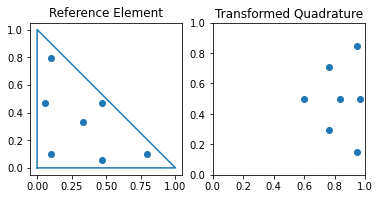

In [8]:
quadPoints = np.zeros((7,2))
# points in the xi direction
quadPoints[0][0] = 1/3;
quadPoints[1][0] = (6 + np.sqrt(15))/21;
quadPoints[2][0] = (9 - 2*np.sqrt(15))/21;
quadPoints[3][0] = (6 + np.sqrt(15))/21;
quadPoints[4][0] = (6 - np.sqrt(15))/21;
quadPoints[5][0] = (9 + 2*np.sqrt(15))/21;
quadPoints[6][0] = (6 - np.sqrt(15))/21;
# eta-values
quadPoints[0][1] = 1/3;
quadPoints[1][1] = (6 + np.sqrt(15))/21;
quadPoints[2][1] = (6 + np.sqrt(15))/21;
quadPoints[3][1] = (9 - 2*np.sqrt(15))/21;
quadPoints[4][1] = (6 - np.sqrt(15))/21;
quadPoints[5][1] = (6 - np.sqrt(15))/21;
quadPoints[6][1] = (9 + 2*np.sqrt(15))/21;


ref_triangle = np.array([[0,0],[1,0],[0,1],[0,0]])

fig, axs = plt.subplots(1,2)
ax = axs[0]
ax.set_aspect("equal")
ax.plot(ref_triangle[:,0],ref_triangle[:,1])
ax.scatter(quadPoints[:,0],quadPoints[:,1])
ax.set_title("Reference Element")
ax = axs[1]
tqP = transform_to_element(quadPoints.T,el_connect[1],node_pos).T
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect("equal")
ax.set_title("Transformed Quadrature")
_ = ax.scatter(tqP[:,0],tqP[:,1])


# Conversion to Matrix Equation
## Assembling the Stiffness Matrix
## Applying Boundary Conditions
### Dirichlet Boundary
### v.N. Boundary